# Variable dz water balance

The purpose of this script is to be able to monitor a run's progress and view how the water balance is progressing (for example during spinup). It should take into consideration variable dz adjustments

In [3]:
from postproc import scale_pfb
import numpy as np

import subprocess
import glob
import os
import shutil
import time
import pandas as pd
from io import StringIO

%matplotlib inline

In [5]:
cur_stop = 43805

In [35]:
8761*10

87610

## Write Silo Files for Water Balance

In [6]:
bashCommand = "tclsh write_wb_silos.tcl %s %s %s" %('slopes_only',0,cur_stop)
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(output)
print(error)

b''
None


## Read in NLDAS input

```
DSWR: Downward Visible or Short-Wave radiation [W/m2 ]. (SW radiation flux downwards)
DLWR: Downward Infa-Red or Long-Wave radiation [W/m2 ] (LW radiation flux downwards)
APCP: Precipitation rate [mm/s]  (Precipitation hourly total)
Temp: Air temperature [K]  (2-m above ground Termperature)
UGRD: West-to-East or U-component of wind [m/s]  (10-m above ground Zonal wind speed)
VGRD: South-to-North or V-component of wind [m/s] (10-m above ground Medional wind speed)
Press: Atmospheric Pressure [pa] (Surface Pressure)
SPFH: Water-vapor specific humidity [kg/kg] (2-m above ground humidity)

```

In [7]:
nldas = pd.read_fwf('./dauphco.nldas.10yr.txt', header = None, sep = '')
nldas.columns = ['DSWR', 'DLWR', 'APCP', 'TMP', 'UGRD', 'VGRD', 'PRESS', 'SPFH']
nldas.head()

,DSWR,DLWR,APCP,TMP,UGRD,VGRD,PRESS,SPFH
0,0.0,306.959991,0.000212,270.720001,-0.66,1.46,98751.226562,0.003161
1,0.0,306.959991,0.000166,270.950012,-0.51,1.10,98789.796875,0.003190
2,0.0,306.959991,0.000200,271.179993,-0.37,0.73,98827.718750,0.003218
3,0.0,306.019989,0.000065,271.410004,-0.22,0.36,98866.281250,0.003247
4,0.0,306.019989,0.000049,271.309998,-0.24,0.18,98764.718750,0.003246


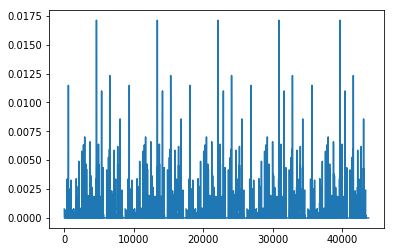

In [8]:
prcp_m_hr = nldas.APCP/1000*60*60 # meters per hour precipitation
prcp_v = prcp_m_hr*1200*1000 # total precip volume over domain (to use in water balance)

prcp_m_hr[:cur_stop].plot.line()

In [9]:
def silo2pfb(bnam, start, stop, fw=0):
    '''
    Converts a timeseries of silo output to pfb format
    (saves converted pfbs to same directory)
    
    bnam     the basename of the files (everything up to the iterating index)
    start    start number of file indexing
    end      end number of file indexing
    fw       fixed width = 0 for non-fixed width iterating index, 
             fixed width = 1 for fixed width (assumed width is 5) index.
    '''
    bashCommand = "tclsh silotopfb_iter_bnam.tcl %s %s %s %s" %(bnam,start,stop, fw)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    print(output)
    print(error)
    
    # if fw =1, rename the output files to remove $runname.out
    if fw:
        print("renaming output pfb files")
        newbnam = bnam.split(".")[-1]
        
        for i in range(start, stop+1):
            ofnam = "%s.%s.pfb" %(bnam,i)
            nfnam = "%s.%s.pfb" %(newbnam,i)
            os.rename(ofnam, nfnam)

def sumoverdomain(bnam, start, stop):
    '''
    Sums over the entire domain for an input pfb file,
    returns a dataframe with columns for t and the sum values
    
    bnam    the base name of the files to sum
    start   the start number of file indexing
    end     the end number of file indexing
    '''
    bashCommand = "tclsh sum_domain_bnam.tcl %s %s %s" %(bnam,start,stop)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    # Save the output to a dataframe
    output = output.decode("utf-8").format()
    df = pd.read_csv(StringIO(output), sep="\t", header = None)
    df.columns = ['t','sum_val']  # add a header (column name)
    
    # return
    return(df)
    

# Apply scale factors for vdz

The scaling factors need to be applied for subsurface storage, and potentially to surface storage and surface runoff as well.

- Need a silotopfb_iter.tcl script that can be applied to various files' base names

In [10]:
factors = np.array([[2.0],  # <- bottom
                    [2.0],
                    [2.0],
                    [1.0],
                    [1.0],
                    [1.0],
                    [0.25],
                    [0.25],
                    [0.25],
                    [0.25]]) # <- top

## Overland Flow 
Overland flow does not need scale factors applied

In [11]:
silo2pfb(bnam ='surface_runoff' , start=1, stop=cur_stop)
of = sumoverdomain(bnam = 'surface_runoff',start = 1, stop= cur_stop)
of.head(10)

b''
None


,t,sum_val
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


## Surface Storage 
Surface storage does not need scale factors applied

In [12]:
silo2pfb(bnam ='surface_storage' , start= 0, stop=cur_stop)
s = sumoverdomain(bnam = 'surface_storage',start = 0, stop= cur_stop)
s.head(10)

b''
None


,t,sum_val
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


## Subsurface storage

In [13]:
# convert silos to pfbs
silo2pfb(bnam ='subsurface_storage' , start= 0, stop=cur_stop)

# scale pfbs using factors
for i in range(0,cur_stop+1):
    infnam = 'subsurface_storage.%s.pfb' %i
    outfnam = 'vdz_subsurface_storage.%s.pfb' %i
    
    scale_pfb(pfbinfnam = infnam, vdzarr = factors, pfboutfnam = outfnam, 
         nx = 12, ny = 10, dx = 10, dy = 10, dz = 1)
    
ss = sumoverdomain(bnam = 'vdz_subsurface_storage',start = 0, stop= cur_stop)
ss.head(10)

b''
None


,t,sum_val
0,0,4.180171e+06
1,1,4.180832e+06
2,2,4.181347e+06
3,3,4.181977e+06
4,4,4.182169e+06
5,5,4.182309e+06
6,6,4.182333e+06
7,7,4.182315e+06
8,8,4.182299e+06
9,9,4.182283e+06


## Evapotranspiration

In [14]:
factors = np.array([[2.0],  # <- bottom
                    [2.0],
                    [2.0],
                    [1.0],
                    [1.0],
                    [1.0],
                    [0.25],
                    [0.25],
                    [0.25],
                    [0.25]]) # <- top

silo2pfb(bnam ='slopes_only.out.evaptranssum' , start= 1, stop=cur_stop, fw = 1)

# scale pfbs using factors
for i in range(1,cur_stop):
    infnam = 'evaptranssum.%s.pfb' %i
    outfnam = 'vdz_evaptranssum.%s.pfb' %i
    
    scale_pfb(pfbinfnam = infnam, vdzarr = factors, pfboutfnam = outfnam, 
         nx = 12, ny = 10, dx = 10, dy = 10, dz = 1)

et = sumoverdomain(bnam = 'vdz_evaptranssum',start = 1, stop= cur_stop)
et['sum_val'] = et['sum_val']
et['t'] = et['t'] - 1
et.head(10)

b''
None
renaming output pfb files


,t,sum_val
0,0,660.859340
1,1,515.315884
2,2,630.040175
3,3,191.688525
4,4,140.107351
5,5,24.103736
6,6,-17.462748
7,7,-16.626906
8,8,-16.001470
9,9,-15.389841


In [15]:
et.tail()

,t,sum_val
43799,43799,72.838426
43800,43800,-3.175808
43801,43801,-2.294077
43802,43802,-1.725638
43803,43803,-1.406502


# Water balance

**NOTE** This will not balance if the run was executed with overland flow keys on! Water will begin to be "lost" from the domain when overland flow occurs.

In [16]:
wb = ss.merge(of, on = 't', how = 'left').merge(s, on = 't', how = 'left').merge(et, on = 't', how = 'left')
wb.columns = ['t', 'vdz_subsurfstor', 'overland_flow', 'surf_stor', 'vdz_et']
wb['overland_flow'] = (- wb['overland_flow'])*2  # flow out of domain is negative  WHY DO I HAVE TO MULTIPLY BY 2 HERE?
wb['overland_flow'] = wb['overland_flow'].shift(-1)  # AND SHIFT BY ONE?
#wb['overland_flow_alt'] = - of_alt['val']
#wb['overland_flow_alt'] = wb['overland_flow_alt'].shift(2)

wb['dom_tot'] = wb['vdz_subsurfstor'] +  wb['surf_stor'] 
wb['bndy_flux'] = wb['vdz_et'] +  wb['overland_flow']  # check signs here...
#wb['bndy_flux_alt'] = wb['vdz_et'] +  wb['overland_flow_alt'] 

wb['exp_wb'] = wb['dom_tot'].shift(-1) + wb['bndy_flux']
#wb['exp_wb_alt'] = wb['dom_tot'].shift(-1) + wb['bndy_flux_alt']

wb['dom_tot_chg'] = wb['dom_tot'].diff()
wb['dom_tot_chg'] = wb['dom_tot_chg'].shift(-1)

wb['diff'] = wb['dom_tot_chg'] - wb['bndy_flux']
#wb['diff_alt'] = wb['dom_tot_chg'] - wb['bndy_flux_alt']
#wb['pc_diff'] = abs(wb['diff'])/wb['dom_tot']*100
wb['pc_diff'] = abs(wb['diff'])/wb['exp_wb']*100
#wb['pc_diff_alt'] = abs(wb['diff_alt'])/wb['exp_wb_alt']*100

wb['prcp_v'] = prcp_v[:cur_stop]





#wb['exp_diff'] = wb['dom_tot'].diff()

#wb['exp_diff'] = wb['bndy_flux']
#wb['exp_wb'] = wb['dom_tot'].shift(-1) + wb['exp_diff']

#wb['pct_diff'] = abs(wb['dom_tot'] - wb['exp_wb'])/wb['exp_wb']*100
#wb['pct_diff'] = (wb['exp_diff'] - wb['bndy_flux'])/wb['exp_diff']*100
wb

,t,vdz_subsurfstor,overland_flow,surf_stor,vdz_et,dom_tot,bndy_flux,exp_wb,dom_tot_chg,diff,pc_diff,prcp_v
0,0,4.180171e+06,-0.000000,0.000000e+00,660.859340,4.180171e+06,660.859340,4.181492e+06,660.859574,2.343074e-04,5.603438e-09,914.4144
1,1,4.180832e+06,-0.000000,0.000000e+00,515.315884,4.180832e+06,515.315884,4.181862e+06,515.315829,-5.535471e-05,1.323686e-09,717.5952
2,2,4.181347e+06,-0.000000,0.000000e+00,630.040175,4.181347e+06,630.040175,4.182607e+06,630.040121,-5.353882e-05,1.280035e-09,862.7904
3,3,4.181977e+06,-0.000000,0.000000e+00,191.688525,4.181977e+06,191.688525,4.182360e+06,191.688524,-1.571147e-06,3.756603e-11,281.5344
4,4,4.182169e+06,-0.000000,0.000000e+00,140.107351,4.182169e+06,140.107351,4.182449e+06,140.107344,-7.483241e-06,1.789201e-10,210.9456
5,5,4.182309e+06,-0.000000,0.000000e+00,24.103736,4.182309e+06,24.103736,4.182357e+06,24.103734,-1.994407e-06,4.768620e-11,56.4192
6,6,4.182333e+06,-0.000000,0.000000e+00,-17.462748,4.182333e+06,-17.462748,4.182298e+06,-17.462405,3.436013e-04,8.215611e-09,0.0000
7,7,4.182315e+06,-0.000000,0.000000e+00,-16.626906,4.182315e+06,-16.626906,4.182282e+06,-16.626920,-1.373979e-05,3.285237e-10,0.0000
8,8,4.182299e+06,-0.000000,0.000000e+00,-16.001470,4.182299e+06,-16.001470,4.182267e+06,-16.001517,-4.682669e-05,1.119649e-09,0.0000
9,9,4.182283e+06,-0.000000,0.000000e+00,-15.389841,4.182283e+06,-15.389841,4.182252e+06,-15.389846,-4.491024e-06,1.073829e-10,0.0000


In [17]:
wb[abs(wb['pc_diff_alt']) > 0.0005]

KeyError: 'pc_diff_alt'

In [18]:
wb[abs(wb['pc_diff']) > 0.0005]

,t,vdz_subsurfstor,overland_flow,surf_stor,vdz_et,dom_tot,bndy_flux,exp_wb,dom_tot_chg,diff,pc_diff,prcp_v


In [19]:
# check what the pct differences are
max(wb.pc_diff.dropna())

1.8846373535335594e-07

In [20]:
wb.shape

(43806, 12)

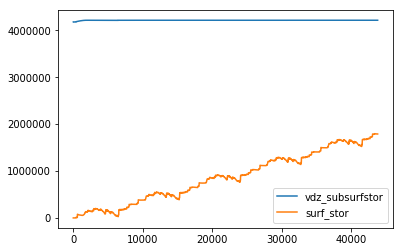

In [21]:
# water in domain
wb[['vdz_subsurfstor', 'surf_stor']].plot.line()

In [34]:
wb['surf_stor'].iloc[np.multiply(8761,[0,1,2,3,4,5])].pct_change()

0             NaN
8761          inf
17522    1.258042
26283    0.572720
35044    0.370172
43805    0.273678
Name: surf_stor, dtype: float64

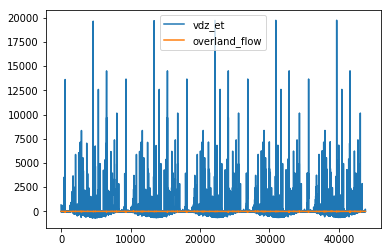

In [22]:
# boundary fluxes
wb[['vdz_et', 'overland_flow']].plot.line()

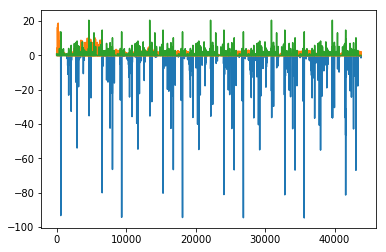

In [23]:
wb['overland_flow'].plot()
(wb['pc_diff']*100000000).plot()
(wb['prcp_v']/1000).plot()

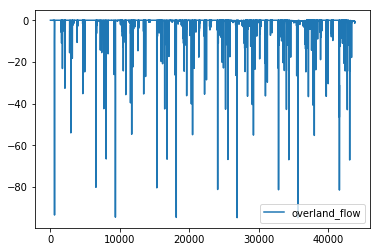

In [24]:
wb[[ 'overland_flow']].plot.line()

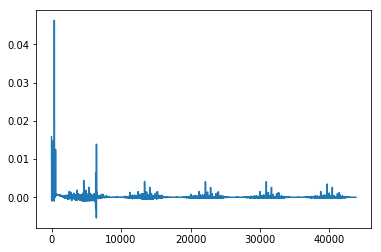

In [25]:
pc_change = wb['vdz_subsurfstor'].pct_change()*100
pc_change.plot.line()